In [ ]:
# titanic, matplotlib, seaborn, warnings, apply, lambda, heatmap, colormap, pairplot, GridSearchCV
# StratifiedKFold, GradientBoostingClassifier, RandomForestClassifier, SVC, LogisticRegression
# XGBClassifier, GridSearchCV.best_params_

# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


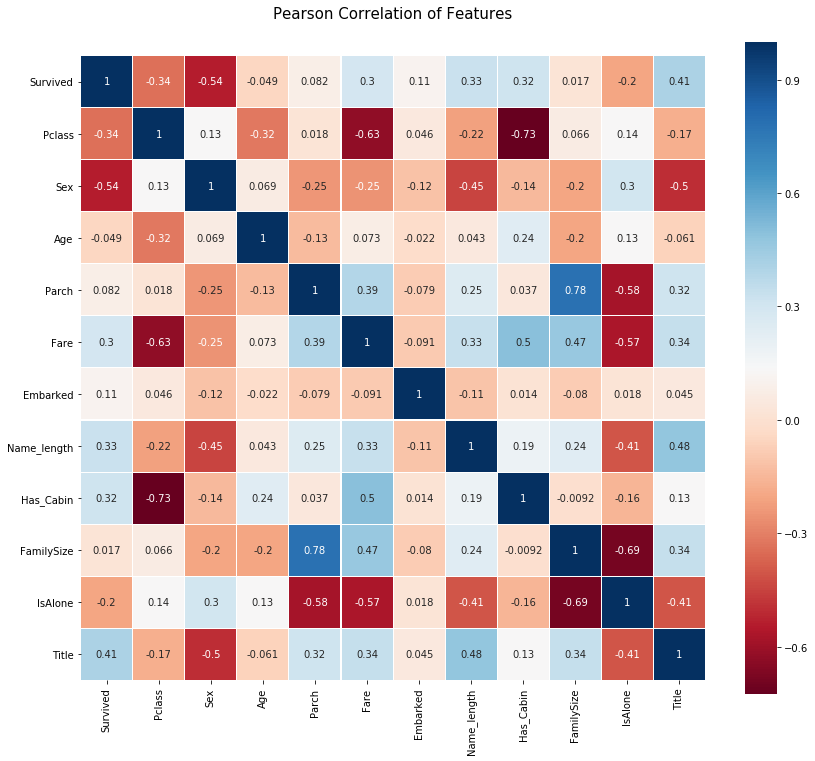

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

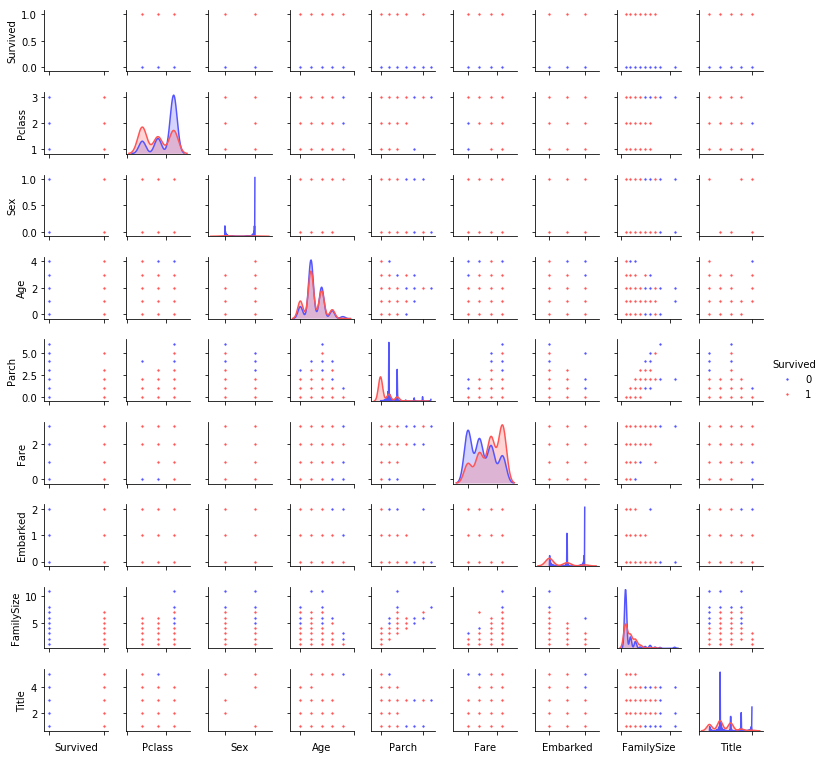

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LinearRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [8]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

In [9]:
rfc = RandomForestClassifier(rfc_params, random_state=17)
svc = SVC(svc_params, random_state=17)
gbc = GradientBoostingClassifier(gbc_params, random_state=17)
lr = LogisticRegression(lr_params, random_state=17)

In [10]:
X = train.drop(columns=['Survived'])
Y = train['Survived']
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=17)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [11]:
gbc.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': {'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5])},
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [12]:
gbc_params = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "n_estimators":[10]
    }
gbc_gs = GridSearchCV(estimator=gbc, cv=skf, param_grid=gbc_params).fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
# ваш код

#rfc_params = {'min_samples_leaf': [1,10]}
rfc_params = { 
    'n_estimators': [500],
    'max_depth' : [4,5,6,7,8]
}
svc_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear']
}
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2']
}
gbc_params = {
    'loss':['deviance'],
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'n_estimators':[10]
}

rfc_gs = GridSearchCV(estimator=rfc, cv=skf, param_grid=rfc_params).fit(x_train, y_train)
svc_gs = GridSearchCV(estimator=svc, cv=skf, param_grid=svc_params).fit(x_train, y_train)
lr_gs = GridSearchCV(estimator=lr, cv=skf, param_grid=lr_params).fit(x_train, y_train)
gbc_gs = GridSearchCV(estimator=gbc, cv=skf, param_grid=gbc_params).fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
print(f'Лучшие параметры для RandomForestClassifier: {rfc_gs.best_params_}')
print(f'Лучшие параметры для SVC: {svc_gs.best_params_}')
print(f'Лучшие параметры для LogisticRegression: {lr_gs.best_params_}')
print(f'Лучшие параметры для GradientBoostingClassifier: {gbc_gs.best_params_}')

Лучшие параметры для RandomForestClassifier: {'max_depth': 8, 'n_estimators': 500}
Лучшие параметры для SVC: {'C': 1, 'kernel': 'linear'}
Лучшие параметры для LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Лучшие параметры для GradientBoostingClassifier: {'learning_rate': 0.2, 'loss': 'deviance', 'n_estimators': 10}


In [15]:
# В соревновании требуется вычислить Accuracy: https://www.kaggle.com/c/titanic/overview/evaluation
from sklearn.metrics import accuracy_score

print(f'Accuracy для RandomForestClassifier: {accuracy_score(rfc_gs.predict(x_valid), y_valid)}')
print(f'Accuracy для SVC: {accuracy_score(svc_gs.predict(x_valid), y_valid)}')
print(f'Accuracy для LogisticRegression: {accuracy_score(lr_gs.predict(x_valid), y_valid)}')
print(f'Accuracy для GradientBoostingClassifier: {accuracy_score(gbc_gs.predict(x_valid), y_valid)}')

Accuracy для RandomForestClassifier: 0.7873134328358209
Accuracy для SVC: 0.7611940298507462
Accuracy для LogisticRegression: 0.7910447761194029
Accuracy для GradientBoostingClassifier: 0.7611940298507462


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [16]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2),
              'max_depth': [6]
             }

In [17]:
# ваш код
xgb = XGBClassifier(xgb_params, random_state=17)
xgb_gs = GridSearchCV(estimator=xgb, cv=skf, param_grid=xgb_params)

meta_mtrx = np.empty((x_valid.shape[0], 4))

meta_mtrx[:, 0] = rfc_gs.predict(x_valid)
meta_mtrx[:, 1] = svc_gs.predict(x_valid)
meta_mtrx[:, 2] = lr_gs.predict(x_valid)
meta_mtrx[:, 3] = gbc_gs.predict(x_valid)

xgb_gs.fit(meta_mtrx, y_valid)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0,
       max_depth={'n_estimators': range(10, 100, 5), 'eta': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'min_ch..._alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 100, 5), 'eta': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'min_child_weight': range(1, 10), 'subsample': array([0.1, 0.3, 0.5, 0.7, 0.9]), 'max_depth': [6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
xgb_gs.best_params_

{'eta': 0.1,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 20,
 'subsample': 0.30000000000000004}

### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [19]:
# ваш код

rfc_stacking = RandomForestClassifier(max_depth=8, random_state=17).fit(X, Y)
svc_stacking = SVC(C=0.1, kernel='linear', random_state=17).fit(X, Y)
gbc_stacking = GradientBoostingClassifier(learning_rate=0.2, loss='deviance', n_estimators=10, random_state=17).fit(X, Y)
lr_stacking = LogisticRegression(C=100, penalty='l1', random_state=17).fit(X, Y)

meta_mtrx = np.empty((test.shape[0], 4))

meta_mtrx[:, 0] = rfc_stacking.predict(test)
meta_mtrx[:, 1] = svc_stacking.predict(test)
meta_mtrx[:, 2] = lr_stacking.predict(test)
meta_mtrx[:, 3] = gbc_stacking.predict(test)

xgb_stacking = XGBClassifier(eta=0.1, max_depth=6, min_child_weight=1, n_estimators=10, subsample=0.9000000000000001, random_state=17).fit(X,Y)
xgb_predict = xgb_stacking.predict(test)

In [20]:
test.head(5)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [21]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [22]:
# ваш код

write_to_submission_file(xgb_predict, 5)

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ:

In [ ]:
# score: 0.77990